<a href="https://colab.research.google.com/github/sn0rkmaiden/dolphin-classifier/blob/main/iNaturalist_dolphin_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

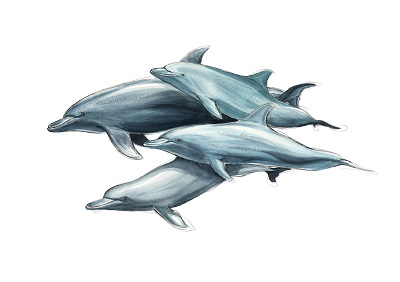

## Imports

In [1]:
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageFile
import glob
import torchvision
from torchvision import models
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import itertools
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
shutil.unpack_archive('/content/drive/MyDrive/dolphins.zip', 'dolphins/')

## Downloading data

In [ ]:
!git clone "https://github.com/cypamigon/inat_downloader.git"

In [2]:
%cd /content/inat_downloader

/content/inat_downloader


In [4]:
dolphins = {'Tursiops truncatus': 0, 'Delphinus delphis': 0, 'Grampus griseus': 0, 'Phocoena phocoena': 0, 'Stenella frontalis': 0}
df_dolphins = pd.DataFrame(dolphins.items(), columns=['name', 'start_id'])
df_dolphins.to_csv('species.csv', index=False)

In [5]:
species = pd.read_csv('species.csv')

In [6]:
species

,name,start_id
0,Tursiops truncatus,0
1,Delphinus delphis,0
2,Grampus griseus,0
3,Phocoena phocoena,0
4,Stenella frontalis,0


In [7]:
!python inat_downloader.py -o 1000

Streaming output truncated to the last 5000 lines.
INFO : 521 images downloaded (44.75 MB)
INFO : Phocoena phocoena - Observation 302/1000 (ID : 22077879)
INFO : 522 images downloaded (44.8 MB)
INFO : Phocoena phocoena - Observation 303/1000 (ID : 22077943)
INFO : 523 images downloaded (44.83 MB)
INFO : 524 images downloaded (44.86 MB)
INFO : Phocoena phocoena - Observation 304/1000 (ID : 22077996)
INFO : 525 images downloaded (44.89 MB)
INFO : Phocoena phocoena - Observation 305/1000 (ID : 22078008)
INFO : 526 images downloaded (44.93 MB)
INFO : Phocoena phocoena - Observation 306/1000 (ID : 22078017)
INFO : 527 images downloaded (44.98 MB)
INFO : 528 images downloaded (45.01 MB)
INFO : Phocoena phocoena - Observation 307/1000 (ID : 22078036)
INFO : 529 images downloaded (45.07 MB)
INFO : 530 images downloaded (45.13 MB)
INFO : Phocoena phocoena - Observation 308/1000 (ID : 22078081)
INFO : 531 images downloaded (45.18 MB)
INFO : Phocoena phocoena - Observation 309/1000 (ID : 22078102

Save images for later use

In [10]:
shutil.make_archive('/content/dolphins', 'zip', '/content/inat_downloader/results')

'/content/dolphins.zip'

In [11]:
%cd ../

/content


## Preprocess

In [4]:
data_path = '/content/dolphins'

In [5]:
os.mkdir('/temp')
os.chdir('/temp')
os.mkdir('train')
os.mkdir('test')

In [6]:
# Split images 75% to 25%
for subfolder in os.listdir(data_path):

    original_path = f'{data_path}/{subfolder}'
    if os.path.isdir(original_path):
      original_data = os.listdir(original_path)

      n_samples = len(original_data)
      train_samples = int(n_samples * 0.75)

      train_path = f'/temp/train/{subfolder}'
      test_path = f'/temp/test/{subfolder}'

      os.chdir('/temp/train')
      if not os.path.exists(subfolder):
        os.mkdir(subfolder)

      # Training images:
      for image in range(train_samples):
          original_file = f'{original_path}/{original_data[image]}'
          new_file = f'{train_path}/{original_data[image]}'
          shutil.copyfile(original_file, new_file)

      os.chdir('/temp/test')
      if not os.path.exists(subfolder):
        os.mkdir(subfolder)

      for image in range(train_samples, n_samples):
          original_file = f'{original_path}/{original_data[image]}'
          new_file = f'{test_path}/{original_data[image]}'
          shutil.copyfile(original_file, new_file)

In [7]:
train_root = '/temp/train'
test_root = '/temp/test'

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.CenterCrop(550),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = torchvision.datasets.ImageFolder(train_root, data_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_root, data_transforms)

In [8]:
batch_size = 40

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

print('number of batches for training:', len(train_dataloader),
      '\nnumber of batches for testing:', len(test_dataloader),
      '\nnumber of images:', len(train_dataset))

number of batches for training: 184 
number of batches for testing: 62 
number of images: 7344


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
class_names = ["Tursiops truncatus", "Delphinus delphis", "Grampus griseus", "Phocoena phocoena",
                "Stenella frontalis"]
ids = ["tensor(0)", "tensor(1)", "tensor(2)", "tensor(3)", "tensor(4)"]

dict_class_names = dict(zip(ids, class_names))
print(dict_class_names)

{'tensor(0)': 'Tursiops truncatus', 'tensor(1)': 'Delphinus delphis', 'tensor(2)': 'Grampus griseus', 'tensor(3)': 'Phocoena phocoena', 'tensor(4)': 'Stenella frontalis'}


📷 Show how images look like

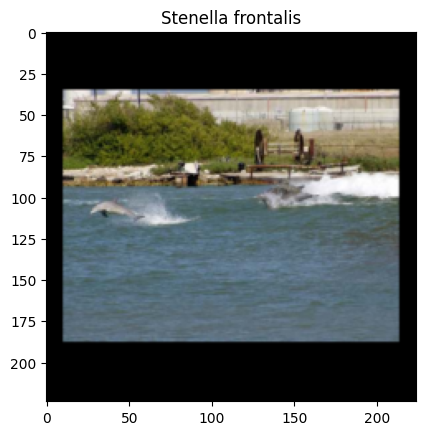

In [10]:
def show_input(input_tensor, title, title_pred=None):
    # input_tensor.shape: (1, 224, 224) => (224, 224, 1)
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    if title_pred is not None:
      plt.title(f'True: {title} Pred: {title_pred}')
    else:
      plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
show_input(X_batch[0], dict_class_names[str(y_batch[0])])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Define model

In [12]:
def train_model(model, num_epochs):

    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        start_time = time.time()

        model.train()  # Set model to training mode

        running_loss = 0.
        running_acc = 0.

        # Iterate over data.
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward and backward
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                # backward + optimize only if in training phase
                loss_value.backward()
                optimizer.step()

            # statistics
            running_loss += loss_value.item()
            running_acc += (preds_class == labels.data).float().mean()

        epoch_loss = running_loss / len(train_dataloader)
        epoch_acc = running_acc / len(train_dataloader)

        scheduler.step()

        print('Loss: {:.4f} Acc: {:.4f} Time: {:.4f}'.format(epoch_loss, epoch_acc, time.time() - start_time), flush=True)

    return model

In [13]:
mobilenet = models.mobilenet_v2(pretrained=True)

for param in mobilenet.parameters():
    param.requires_grad = False

mobilenet.classifier[1] = torch.nn.Sequential(
    torch.nn.Linear(mobilenet.classifier[1].in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, len(dict_class_names))
)

mobilenet = mobilenet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 103MB/s] 


## Training

In [14]:
mobilenet = train_model(mobilenet, num_epochs=15)

Epoch 0/14:
Loss: 1.1869 Acc: 0.5240 Time: 63.1240
Epoch 1/14:
Loss: 1.0483 Acc: 0.5886 Time: 73.9401
Epoch 2/14:
Loss: 0.9968 Acc: 0.6104 Time: 60.5119
Epoch 3/14:
Loss: 0.9604 Acc: 0.6245 Time: 60.7732
Epoch 4/14:
Loss: 0.9238 Acc: 0.6361 Time: 73.3900
Epoch 5/14:
Loss: 0.8606 Acc: 0.6674 Time: 66.7925
Epoch 6/14:
Loss: 0.8408 Acc: 0.6678 Time: 70.7931
Epoch 7/14:
Loss: 0.8262 Acc: 0.6829 Time: 60.9044
Epoch 8/14:
Loss: 0.8171 Acc: 0.6838 Time: 60.3237
Epoch 9/14:
Loss: 0.8098 Acc: 0.6912 Time: 72.7966
Epoch 10/14:
Loss: 0.7730 Acc: 0.7048 Time: 59.7391
Epoch 11/14:
Loss: 0.7696 Acc: 0.7008 Time: 65.6092
Epoch 12/14:
Loss: 0.7581 Acc: 0.7056 Time: 60.8411
Epoch 13/14:
Loss: 0.7533 Acc: 0.7117 Time: 62.3770
Epoch 14/14:
Loss: 0.7563 Acc: 0.7127 Time: 73.8286


## Evaluate

In [15]:
def accuracy(model):
    model.eval()
    correct = 0

    for inputs, labels in test_dataloader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            preds = model(inputs)

            for label, pred in zip(labels, preds):
                label = int(label.data.cpu().numpy())
                pred = int(torch.argmax(pred).data.cpu().numpy())
                if label == pred:
                    correct += 1

    return correct / len(test_dataset)

In [16]:
print(f"MobileNet's accuracy: {accuracy(mobilenet)}")

MobileNet's accuracy: 0.6627194773376889


In [17]:
def get_target_and_prediction(model):
    model.eval()

    targets = []
    predictions = []

    for inputs, labels in test_dataloader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            preds = model(inputs)

            for label, pred in zip(labels, preds):
                label = int(label.data.cpu().numpy())
                pred = int(torch.argmax(pred).data.cpu().numpy())

                targets.append(label)
                predictions.append(pred)

    return targets, predictions

In [18]:
def create_confusion_matrix(model):
    targets, preditions = get_target_and_prediction(model)
    cm = confusion_matrix(targets, preditions)
    return cm

In [19]:
def plot_confusion_matrix(model, normalize=False):
    cm = create_confusion_matrix(model)
    cmap = plt.cm.Blues

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


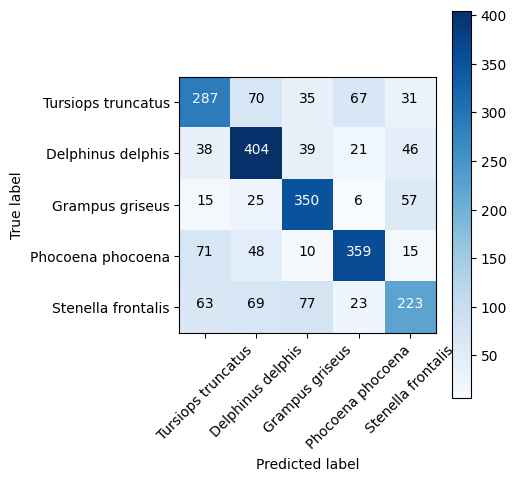

In [20]:
plt.figure(figsize=(5,5))
plot_confusion_matrix(mobilenet)

In [21]:
t, p = get_target_and_prediction(mobilenet)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


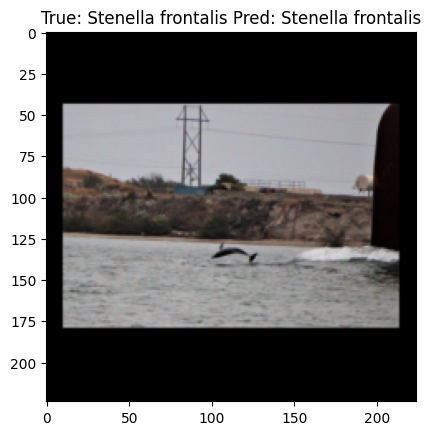

In [68]:
X_batch, y_batch = next(iter(test_dataloader))
prediction = mobilenet(X_batch.to(device))
prediction = int(torch.argmax(prediction[0]).data.cpu().numpy())
show_input(X_batch[0], dict_class_names[str(y_batch[0])], title_pred=dict_class_names[f'tensor({prediction})'])